In [1]:
import os, sys
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import numpy as np
import qutip as qt
from tqdm import tqdm
import matplotlib.pyplot as plt

import time
import jax
import flax
import netket as nk
import jax.numpy as jnp
import flax.linen as nn
import optax
from netket.operator import LocalOperator

from scipy.interpolate import PchipInterpolator
import copy
from functools import partial

from scipy.linalg import eig, inv

import netket_pro as nkp
import netket_pro.jumps as nkj

from netket.operator.spin import sigmax,sigmay,sigmaz,sigmam,sigmap
from netket.vqs import MCState, FullSumState

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
def overlap(s1, s2):
    return s1.conj().T @ s2

def fidelity(s1, s2):
    F = overlap(s1, s2) * overlap(s2, s1) / overlap(s1, s1) / overlap(s2, s2)
    return jnp.abs(F.item())

In [9]:
def _prepare_operators(H, c_ops, e_ops):
    c_tot = sum([c.H@c for c in c_ops])
    H_eff = H - 0.5j * c_tot 
    Hd, Hod = nkj.operations.split_hamiltonian(H_eff)
    apply_exp_diagH = nkj.operations.get_apply_exp_diagH(Hd)
    
    c_ops = [copy.copy(c) for c in c_ops]
    e_ops = [copy.copy(e) for e in e_ops]
    return Hod, apply_exp_diagH, c_ops, e_ops

def _save_state(psi, e_ops, obs_dict):
    expvals = [psi.expect(e).real().mean.item() for e in e_ops]
    obs_dict["states"].append(copy.copy(psi))
    obs_dict["expect"].append(expvals)
    obs_dict["hilbert"].append(psi.hilbert)

def _midpoint_step(psi, phi, dt, f_diag, Hod, optimizer, cv_coeff, n_iter, target_infidelity, obs_dict, SR_maxiter, SR_diag_shift, do_log=True):
    # Diagonal evolution
    f_diag(psi, scale=0.5*dt)
    phi.variables = psi.variables
    
    # Off-diagonal evolution
    logger = nk.logging.RuntimeLog()
    if SR_maxiter > 0:
        preconditioner = nk.optimizer.SR(solver=partial(jax.scipy.sparse.linalg.cg, maxiter=SR_maxiter), diag_shift=SR_diag_shift, holomorphic=True)
    else:
        preconditioner = nk.optimizer.identity_preconditioner
        
    te = nkp.driver.MidpointInfidelityOptimizer(
        phi,
        optimizer,
        variational_state=psi,
        H = Hod,
        dt = dt,
        cv_coeff=cv_coeff,
        preconditioner=preconditioner,
    )
    te.run(n_iter=n_iter, out=logger, show_progress=False, target_infidelity=target_infidelity)
    phi.variables = psi.variables
    
    # Diagonal evolution
    f_diag(psi, scale=0.5*dt)
    phi.variables = psi.variables
    
    #logger_save
    if do_log:
        zadd = n_iter - logger.data["Infidelity"]["Mean"].size
        mean = jnp.abs(logger.data["Infidelity"]["Mean"])
        mean = jnp.pad(mean, (0,zadd), constant_values=0)
        obs_dict["infidelity_mean"].append(mean)
        
        var = logger.data["Infidelity"]["Variance"]
        var = jnp.pad(var, (0,zadd), constant_values=0)
        obs_dict["infidelity_var"].append(var)
    

def dynamics_with_jumps(H, c_ops, e_ops, variational_state, dt, tf, SR_maxiter=10, SR_diag_shift=1e-4,
                                    cv_coeff=None, n_iter=100, optimizer=nk.optimizer.Adam(learning_rate=0.01),
                                    target_infidelity=None, to_zero=1e-12):
    psi = variational_state
    phi = copy.copy(psi)
        
    # Create integration handles
    obs_dict = {"expect": [], "states": [], "times": [], "infidelity_mean": [], "infidelity_var": [], "hilbert": []}
    
    # Prepare evolution handles
    Hod, apply_exp_diagH, c_ops, e_ops = _prepare_operators(H, c_ops, e_ops)
    _step = lambda dt, n_iter, do_log=True: _midpoint_step(psi, phi, dt, apply_exp_diagH, Hod, optimizer, cv_coeff, n_iter, target_infidelity, obs_dict, SR_maxiter, SR_diag_shift, do_log=do_log)
    _save = lambda : _save_state(psi, e_ops, obs_dict)
    
    ## TIME EVOLUTION
    t = 0.
    add_iter = 0
    clock = time.time()
    print("Starting time evolution")
    while t <= tf-dt:
        # Save state and expectation values
        _save()
        obs_dict["times"].append(t)

        _step(dt, n_iter + add_iter)
        t+=dt
            
        completion = 100*t/tf
        elapsed_time = time.time()-clock
        remaining_time = elapsed_time/completion*(100-completion)
        print("\r Completion: {:.2f}%".format(completion), end=" Elapsed time: {:.2f}s".format(elapsed_time)+" Remaining time: {:.2f}s".format(remaining_time))
        
        
    print("\r Completion: 100%", "Elapsed time: {:.2f}s".format(time.time()-clock))
    print("Done!")    
    
    expect = jnp.array(obs_dict["expect"]).T
    obs_dict["expect"] = expect
    obs_dict["times"] = jnp.array(obs_dict["times"])
    obs_dict["infidelity_mean"] = jnp.array(obs_dict["infidelity_mean"])
    obs_dict["infidelity_var"] = jnp.array(obs_dict["infidelity_var"])
    
    return obs_dict

In [10]:
# INTEGRATOR
def exact_integrator(psi0, dt, tf, e_ops, exp_Heff_dt):
    psi = psi0
    phi = copy.copy(psi)
    
    t_list = []
    expect = []
    psi_list = []
    phi_list = []
    
    Heff_exact_step, Hd_exact_step, Hod_exact_step = exp_Heff_dt(dt)
    
    t = 0.
    while t <= tf-dt:
        psi_list.append(psi)
        phi_list.append(phi)
        expect.append([np.real(qt.expect(e, psi/psi.norm())) for e in e_ops])
        t_list.append(t)

        psi = Heff_exact_step(psi)
        
        phi = Hd_exact_step(phi)
        phi = Hod_exact_step(phi)
        phi = Hd_exact_step(phi)
        t+=dt
        
    t_list = np.array(t_list)
    expect = np.array(expect).T
    return t_list, expect, psi_list, phi_list

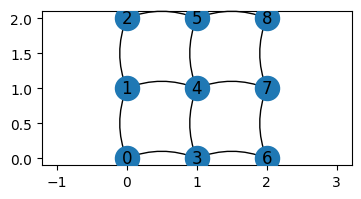

In [5]:
# Define geometry
Lx, Ly = 3, 3
g  = nk.graph.Grid((Lx, Ly), pbc=False)
g.draw(figsize=(4,2))
N  = g.n_nodes
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes, inverted_ordering=False)

γ = 1
h = 0.3
J = -1.

H_diag = sum([J * sigmaz(hi, i) * sigmaz(hi, j) for i,j in g.edges()]) 
H_offd = sum([h * sigmax(hi, i) for i in g.nodes()])
H      = H_diag + H_offd
c_ops  = [np.sqrt(γ) * sigmam(hi,i) for i in g.nodes()]
e_ops  = [sum([sigmaz(hi,i) for i in g.nodes()])/N, sum([sigmax(hi,i) for i in g.nodes()])/N] + [sigmaz(hi,i) for i in g.nodes()]

In [6]:
dt = 0.05
tf = 2.

In [7]:
alpha = 9
model = nkj.networks.RBM(alpha=alpha, param_dtype=complex)
model = nkj.networks.ExtendedNetwork(model, param_dtype=complex, kernel_two_body_init=nn.initializers.normal(), delta_dw_init=nn.initializers.normal(), delta_up_init=nn.initializers.normal())
vgs = nk.vqs.FullSumState(hi, model)

with open("initial_state_3x3_alpha=%d.mpack"%alpha, 'rb') as file:
  vgs = flax.serialization.from_bytes(vgs, file.read())

In [11]:
# Define the variational state
sampler = nk.sampler.ExactSampler(hi) #nk.sampler.MetropolisLocal(hilbert=hi, n_chains_per_rank_or_device=16)
psi = nk.vqs.FullSumState(hi, model) #nk.vqs.MCState(sampler=sampler, model=model, n_samples=5000)
psi.variables = vgs.variables

# Optimization parameters
lr = 1e-2
SR_maxiter = 90
SR_diag_shift = 1e-3
n_iter = 100
optimizer = optax.adabelief(learning_rate=lr,)

# Define handles for exact evolution
Heff_qo   = (H - 1j/2 * sum([c.H@c for c in c_ops])).to_qobj()
Heffd_qo  = qt.Qobj(np.diag(Heff_qo.diag()) , dims=Heff_qo.dims)
Heffod_qo = Heff_qo - Heffd_qo 
c_ops_qo = [c.to_qobj() for c in c_ops]
e_ops_qo = [e.to_qobj() for e in e_ops]
psi0_qo  = psi.to_qobj()

λ, R = eig(Heff_qo.full())
L = inv(R)
def exp_Heff_dt(dt):
    exp_Heff = R @ np.diag(np.exp(-1j*λ*dt)) @ L
    exact = qt.Qobj( exp_Heff , dims=Heff_qo.dims )
    
    exp_Heff_diag = np.diag(np.exp(-1j*Heffd_qo.diag() * dt/2)) #note the factor 1/2
    exact_diag = qt.Qobj( exp_Heff_diag , dims=Heffd_qo.dims ) 
    
    h = np.diag(np.ones(2**N)) + 1j * dt/2 * Heffod_qo.full()
    midpoint_offdiag = qt.Qobj( inv(h) @ h.conj().T , dims=Heffod_qo.dims )
    return lambda psi: exact * psi, lambda psi: exact_diag * psi, lambda psi: midpoint_offdiag * psi
    

# Define additional parameters for the integrator
cv_coeff = -0.5
to_zero  = 1e-12
target_infidelity = 1e-12

# Evolve
ts, expect_ED, psi_ED, phi_ED = exact_integrator(psi0_qo, dt, tf, e_ops_qo, exp_Heff_dt)

obs_dict = dynamics_with_jumps(H, c_ops, e_ops, psi, dt, tf, SR_maxiter=SR_maxiter, SR_diag_shift=SR_diag_shift,
                               target_infidelity=target_infidelity, cv_coeff=cv_coeff, to_zero=to_zero,
                               n_iter=n_iter, optimizer=optimizer,)

Starting time evolution
 Completion: 100% Elapsed time: 210.23s3s Remaining time: 5.39ss
Done!


In [12]:
expect = obs_dict["expect"]
infidelity_mean = obs_dict["infidelity_mean"] 
infidelity_var = obs_dict["infidelity_var"] 
states = obs_dict["states"]
times = obs_dict["times"]

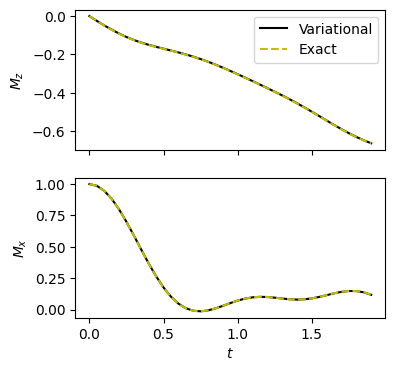

In [20]:
fig, ax = plt.subplots(2,1, figsize=(4,4), sharex=True)

for i in range(2):
    ax[i].plot(times, expect[i]   , "k"  , label="Variational")
    ax[i].plot(ts, expect_ED[i], "y--", label="Exact")
    # ax[i].set_ylim(-1.1,1.1)

ax[+0].set_ylabel(r"$M_z$")
ax[+1].set_ylabel(r"$M_x$")
ax[-1].set_xlabel(r"$t$")
ax[0].legend();

Infdelity  1.469573622381315e-05
Initial infidelity: 2.6643e-03, Final infidelity: 1.7620e-06


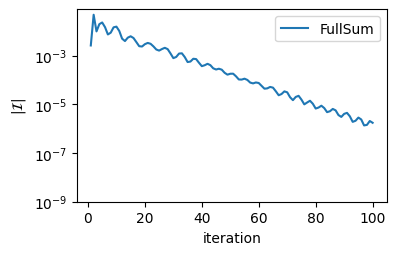

In [21]:
t  =  0.3
it = np.argmin(np.abs(ts-t))
I  = infidelity_mean[it]

wf_true = psi_ED[it+1].full().ravel()
wf_true = wf_true / np.linalg.norm(wf_true)
prob_true = np.abs(wf_true)**2

wf = states[it+1].to_array()
wf = wf / np.linalg.norm(wf)
prob = np.abs(wf)**2

s1 = wf
s2 = wf_true
print("Infdelity ", 1. - fidelity(s1,s2))

fig,ax = plt.subplots(1,1, figsize=(4.,2.5), gridspec_kw={"wspace":0.4})
ax.plot(np.arange(len(I))+1, I, label="FullSum")
ax.legend()
print(f"Initial infidelity: {I[0]:.4e}, Final infidelity: {I[-1]:.4e}")

# ax[0].set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$|\mathcal{I}|$")
ax.set_xlabel(r"iteration")
ax.set_ylim(bottom=1e-9);

Final infidelity: 3.608e-05
Derivative at the end: -1.650e-05


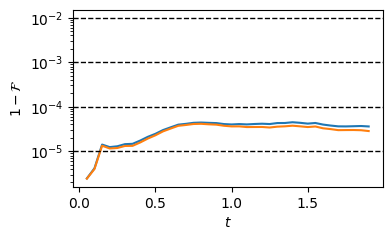

In [25]:
fig,ax = plt.subplots(1,1, figsize=(4.,2.3), gridspec_kw={"wspace":0.4}, sharex=True)

vecs  = [s.to_array(normalize=True) for s in states]
vecs_ed = [s.unit().full().flatten() for s in psi_ED]

norms = [np.linalg.norm(s.to_array(normalize=False)) for s in states]
infs  = [1. - fidelity(s1,s2) for s1,s2 in zip(vecs, vecs_ed)]

vecs_ed = [s.unit().full().flatten() for s in phi_ED]
infs_1  = [1. - fidelity(s1,s2) for s1,s2 in zip(vecs, vecs_ed)]

ax.plot(ts[1:], infs[1:])
ax.plot(ts[1:], infs_1[1:])
ax.set_yscale("log")

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$1 - \mathcal{F}$")

ax.axhline(1e-2, c="k", ls="--", lw=1)
ax.axhline(1e-3, c="k", ls="--", lw=1)
ax.axhline(1e-4, c="k", ls="--", lw=1)
ax.axhline(1e-5, c="k", ls="--", lw=1);

print("Final infidelity: %.3e" % infs[-1])
print("Derivative at the end: %.3e" % ((infs[-1]-infs[-2])/dt) )